In [30]:
!pip install xgboost
!pip install imblearn



In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression


from xgboost import XGBClassifier
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, average_precision_score,roc_curve, precision_recall_curve, hamming_loss
%matplotlib inline


from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import gc

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
data=pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/train_test_network.csv")


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  211043 non-null  object 
 1   src_port                211043 non-null  int64  
 2   dst_ip                  211043 non-null  object 
 3   dst_port                211043 non-null  int64  
 4   proto                   211043 non-null  object 
 5   service                 211043 non-null  object 
 6   duration                211043 non-null  float64
 7   src_bytes               211043 non-null  int64  
 8   dst_bytes               211043 non-null  int64  
 9   conn_state              211043 non-null  object 
 10  missed_bytes            211043 non-null  int64  
 11  src_pkts                211043 non-null  int64  
 12  src_ip_bytes            211043 non-null  int64  
 13  dst_pkts                211043 non-null  int64  
 14  dst_ip_bytes        

In [35]:
data.columns

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service',
       'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes',
       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA',
       'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed',
       'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'type'],
      dtype='object')

In [36]:
data=data.drop_duplicates()

In [37]:
data.isnull().sum()

,0
src_ip,0
src_port,0
dst_ip,0
dst_port,0
proto,0
service,0
duration,0
src_bytes,0
dst_bytes,0
conn_state,0


In [38]:
data.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [39]:
data['type'].value_counts()

,count
type,
normal,42040
scanning,20000
ddos,19993
injection,19964
password,19861
dos,18992
backdoor,18711
xss,15137
ransomware,14735


In [40]:
data["label"].value_counts()

,count
label,
1,148434
0,42040


In [41]:

encoders = {}

cat_cols = ['src_ip', 'dst_ip', 'proto', 'service', 'conn_state', 'dns_query',
       'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version',
       'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject',
       'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri',
       'http_version', 'http_user_agent', 'http_orig_mime_types',
       'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice',
       'type']
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    encoders[col] = le

In [42]:
Y = data[['type','label']]
X= data.drop(["type","label"],axis=1)

In [43]:
label_mapping = dict(zip(range(len(encoders["type"].classes_)), encoders["type"].classes_))
print(label_mapping)


{0: 'backdoor', 1: 'ddos', 2: 'dos', 3: 'injection', 4: 'mitm', 5: 'normal', 6: 'password', 7: 'ransomware', 8: 'scanning', 9: 'xss'}


In [44]:
X.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_version,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice
0,26,4444,201,49178,1,0,290.371539,101568,2592,0,...,0,0,0,0,0,0,0,0,0,0
1,16,49180,210,8080,1,0,0.000102,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,16,49180,210,8080,1,0,0.000148,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,16,49180,210,8080,1,0,0.000113,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,16,49180,210,8080,1,0,0.000130,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [45]:
mi_label = mutual_info_classif(X, Y["label"])
mi_type = mutual_info_classif(X, Y["type"])
mi_avg = (mi_label + mi_type ) / 2

df_mi = pd.DataFrame({
    'feature': X.columns.tolist(),
    'MI_label': mi_label,
    'MI_type': mi_type,
    'MI_average': mi_avg
})

df_mi_sorted = df_mi.sort_values(by='MI_average', ascending=False)
top_features = df_mi_sorted.head(20)['feature'].tolist()
X = X[top_features]


In [46]:
top_features

['src_ip_bytes',
 'src_ip',
 'dst_port',
 'dst_ip_bytes',
 'src_port',
 'dst_ip',
 'conn_state',
 'duration',
 'src_bytes',
 'dst_bytes',
 'src_pkts',
 'dst_pkts',
 'service',
 'dns_query',
 'proto',
 'dns_rejected',
 'dns_RA',
 'dns_qtype',
 'dns_RD',
 'dns_AA']

In [47]:
model = XGBClassifier(tree_method='hist', n_jobs=-1)
model.fit(X, Y["label"])

model1 = XGBClassifier(tree_method='hist', n_jobs=-1)
model1.fit(X, Y["type"])



importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features = importance_df['feature'].head(15)

importances = model1.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features1 = importance_df['feature'].head(15)



combined_features = set(top_features) | set(top_features1)
X = X[list(combined_features)]

In [48]:
combined_features

{'conn_state',
 'dns_RA',
 'dns_RD',
 'dns_qtype',
 'dns_rejected',
 'dst_bytes',
 'dst_ip',
 'dst_ip_bytes',
 'dst_pkts',
 'dst_port',
 'duration',
 'proto',
 'service',
 'src_bytes',
 'src_ip',
 'src_ip_bytes',
 'src_pkts',
 'src_port'}

In [49]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [51]:
X_train.shape

(152379, 18)

In [54]:
y_train[y_train["label"]==0].shape

(33632, 2)

In [56]:
y_test[y_test["label"]==0].shape

(8408, 2)

In [23]:
y_all = y_train[['label', 'type']].reset_index(drop=True)

# Apply SMOTE to balance label = 0 (normal)
sm = SMOTE(k_neighbors=3, random_state=42)
X_resampled, y_label_resampled = sm.fit_resample(X_train, y_all['label'])

# Count synthetic samples
n_original = len(X_train)
n_total = len(X_resampled)
n_synthetic = n_total - n_original

# Original types (before SMOTE)
type_original = y_all['type'].iloc[:n_original].tolist()

# Get encoded value for 'Normal' from original data (you mentioned it's 5)
normal_encoded = 5

# Assign 'Normal' type (5) to all synthetic samples
synthetic_types = [normal_encoded] * n_synthetic

# Combine type and label
type_final = type_original + synthetic_types
label_final = y_label_resampled.tolist()

# Final DataFrame
y_train_resampled = pd.DataFrame({
    'type': type_final,
    'label': label_final
})

# Update X and y
X_train = X_resampled
y_train = y_train_resampled

In [26]:
y_train[y_train["label"]==0].shape

(118747, 2)

In [27]:
y_test[y_test["label"]==1].shape

(29687, 2)

In [ ]:
class RandomForest:
    def __init__(self,max_depth):
        self.rfc_label = RandomForestClassifier(max_depth=max_depth)
        self.rfc_type = RandomForestClassifier(max_depth=max_depth)

    def fit(self,X_train,y_train):
        self.rfc_label.fit(X_train,y_train['label'])

        features_type = np.concatenate((X_train,np.array(y_train['label']).reshape(-1,1)),axis=1)
        self.rfc_type.fit(features_type,y_train['type'])


    def predict(self,X_test):
        predict_label = self.rfc_label.predict(X_test)
        y_proba=self.rfc_label.predict_proba(X_test)[:,1]
        test_type = np.concatenate((X_test,predict_label.reshape(-1,1)),axis=1)
        predict_type = self.rfc_type.predict(test_type)





        return pd.DataFrame({'label':predict_label,'type':predict_type,"y_proba":y_proba})

In [ ]:
def display_metrics(y_true, y_pred, title, y_proba=None):
    print(f"\n--- {title} ---")

    # Classification report
    print("\n📋 Classification Report:")
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report.iloc[:-3])  # Skip last 3 rows for summary clarity

    # Confusion Matrix
    print("\n📊 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Basic Scores
    acc = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    ham_loss = hamming_loss(y_true, y_pred)

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ Weighted F1 Score: {f1_weighted:.4f}")
    print(f"✅ Macro F1 Score: {f1_macro:.4f}")
    print(f"✅ Macro Precision: {precision_macro:.4f}")
    print(f"✅ Macro Recall: {recall_macro:.4f}")
    print(f"❌ Hamming Loss: {ham_loss:.6f}")

    # ROC, PR Curves for Binary
    if y_proba is not None:
        n_classes = pd.Series(y_true).nunique()
        if n_classes == 2:
            roc_auc = roc_auc_score(y_true, y_proba)
            pr_auc = average_precision_score(y_true, y_proba)
            print(f"📈 ROC AUC Score: {roc_auc:.4f}")
            print(f"📈 PR AUC Score: {pr_auc:.4f}")

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(y_true, y_proba)
            plt.figure()
            plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

**Random Forest**

In [ ]:
rf = RandomForest(max_depth=3)
rf.fit(X_train,y_train)

predictions_rfc = rf.predict(X_test)




--- label Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999870  0.916746  0.956506   8408.0
1   0.976963  0.999966  0.988331  29687.0

📊 Confusion Matrix:


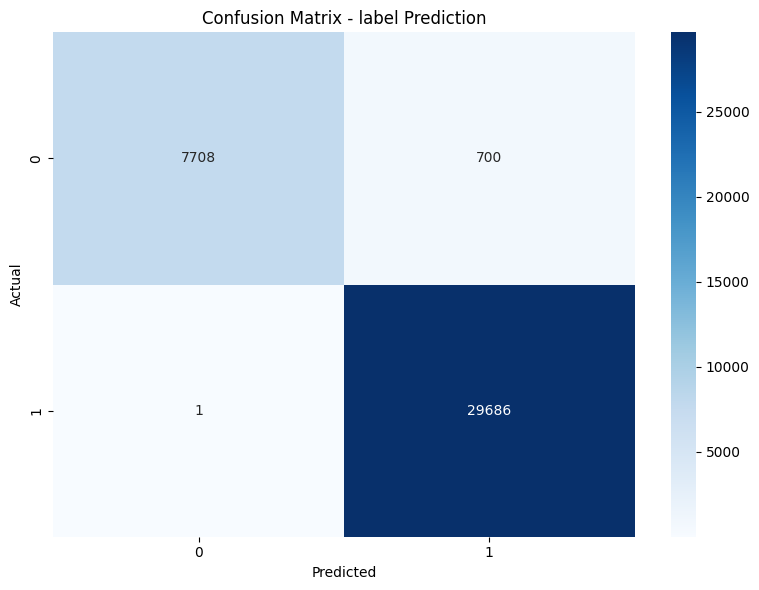


✅ Accuracy: 0.9816
✅ Weighted F1 Score: 0.9813
✅ Macro F1 Score: 0.9724
✅ Macro Precision: 0.9884
✅ Macro Recall: 0.9584
❌ Hamming Loss: 0.018401
📈 ROC AUC Score: 0.9974
📈 PR AUC Score: 0.9992


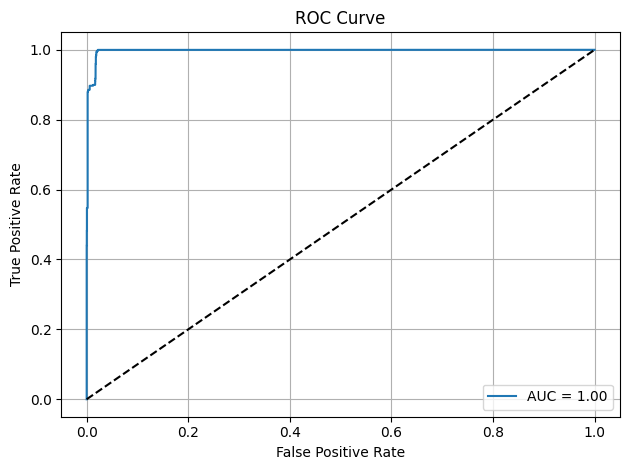

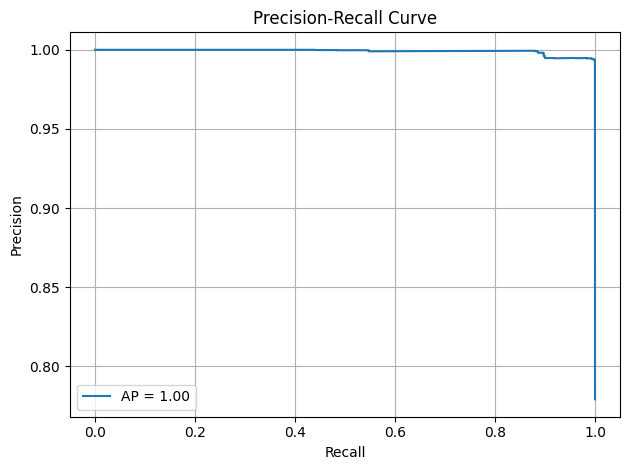

In [ ]:
display_metrics(y_test['label'], predictions_rfc['label'], "label Prediction",predictions_rfc["y_proba"])




--- type Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.966667  0.991983  0.979161   3742.0
1   0.677119  0.890973  0.769463   3999.0
2   0.995686  0.911292  0.951622   3799.0
3   0.728408  0.891310  0.801667   3993.0
4   0.154786  0.730769  0.255462    208.0
5   0.999873  0.939106  0.968537   8408.0
6   0.993050  0.683535  0.809723   3972.0
7   0.886508  0.996607  0.938339   2947.0
8   0.981772  0.956000  0.968714   4000.0
9   0.941404  0.562603  0.704301   3027.0

📊 Confusion Matrix:


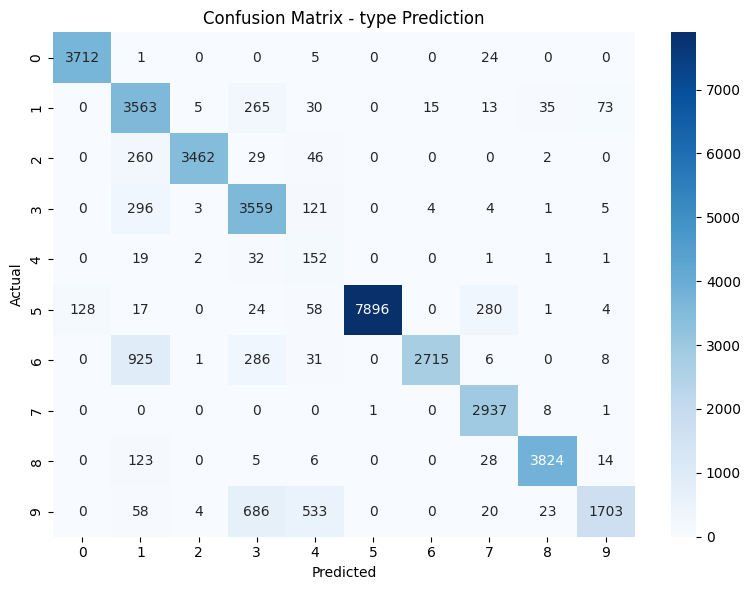


✅ Accuracy: 0.8800
✅ Weighted F1 Score: 0.8857
✅ Macro F1 Score: 0.8147
✅ Macro Precision: 0.8325
✅ Macro Recall: 0.8554
❌ Hamming Loss: 0.120016


In [ ]:
display_metrics(y_test['type'], predictions_rfc['type'], "type Prediction")


XGB graddient boosting


In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["label"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:14:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- label Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999762  0.999881  0.999822   8408.0
1   0.999966  0.999933  0.999949  29687.0

📊 Confusion Matrix:


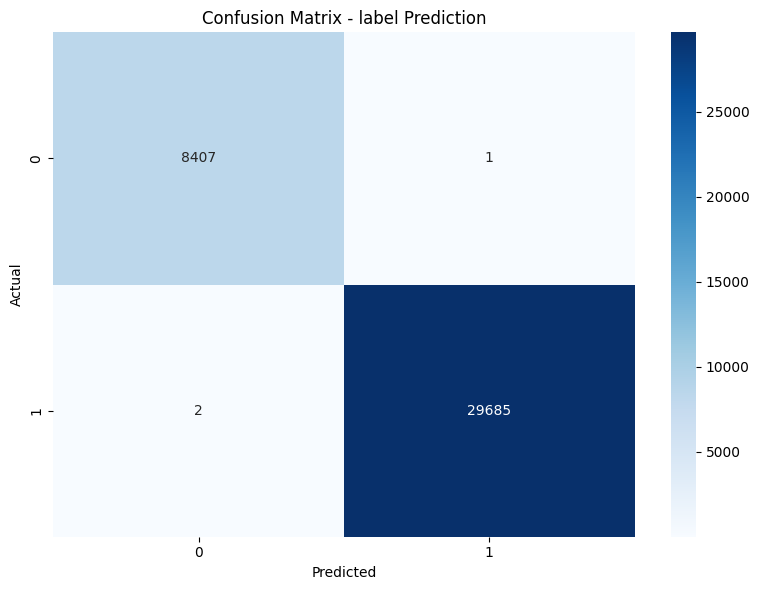


✅ Accuracy: 0.9999
✅ Weighted F1 Score: 0.9999
✅ Macro F1 Score: 0.9999
✅ Macro Precision: 0.9999
✅ Macro Recall: 0.9999
❌ Hamming Loss: 0.000079
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


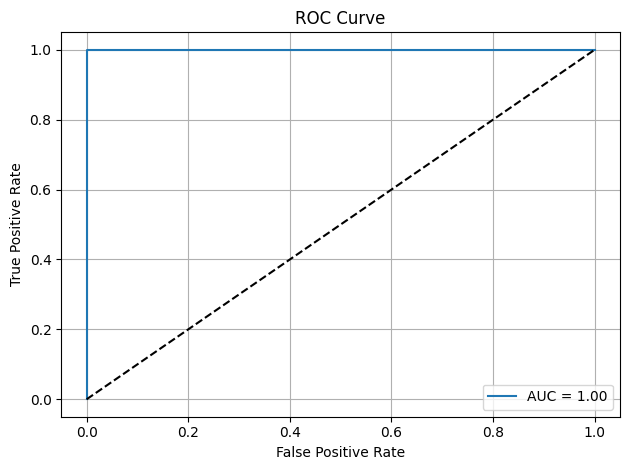

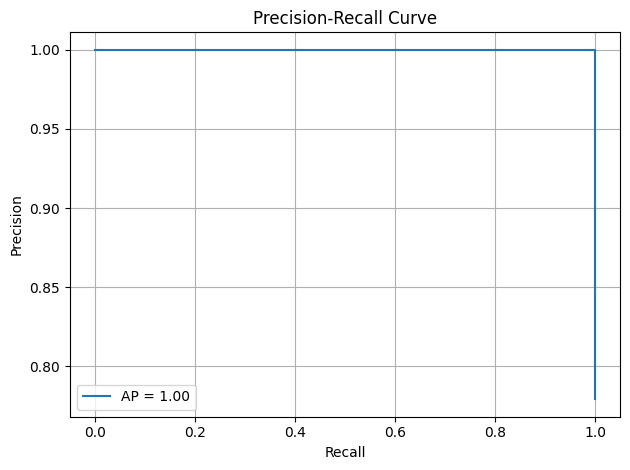

In [ ]:
display_metrics(y_test['label'], y_pred_xgb, "label Prediction",y_proba)


In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["type"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:14:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- type Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   1.000000  1.000000  1.000000   3742.0
1   0.994488  0.992498  0.993492   3999.0
2   0.993398  0.990261  0.991827   3799.0
3   0.990736  0.990984  0.990860   3993.0
4   0.873362  0.961538  0.915332    208.0
5   0.999762  0.999881  0.999822   8408.0
6   0.996965  0.992447  0.994701   3972.0
7   0.999661  1.000000  0.999830   2947.0
8   0.991530  0.995000  0.993262   4000.0
9   1.000000  1.000000  1.000000   3027.0

📊 Confusion Matrix:


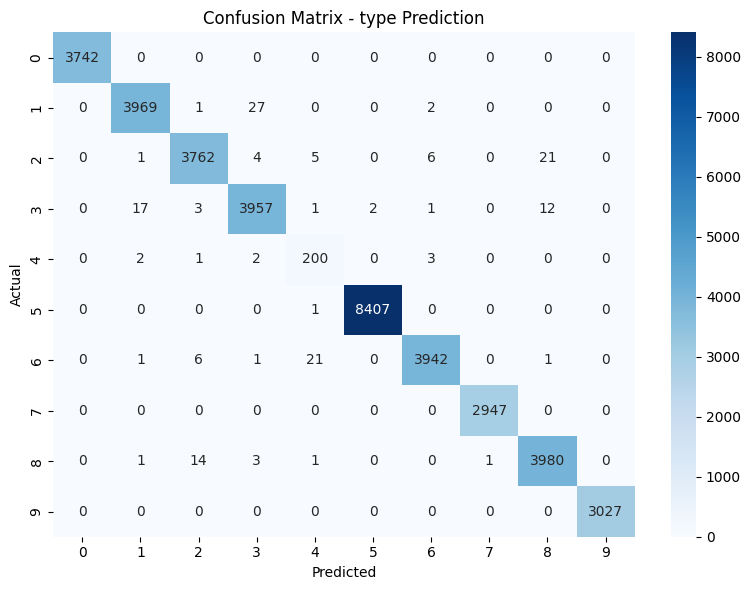


✅ Accuracy: 0.9957
✅ Weighted F1 Score: 0.9958
✅ Macro F1 Score: 0.9879
✅ Macro Precision: 0.9840
✅ Macro Recall: 0.9923
❌ Hamming Loss: 0.004253


In [ ]:
display_metrics(y_test['type'], y_pred_xgb, "type Prediction")

Logistic Regression


In [ ]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["label"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)

y_proba = logreg_model.predict_proba(X_test)[:, 1]


--- label Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.990800  0.922217  0.955279   8408.0
1   0.978394  0.997575  0.987891  29687.0

📊 Confusion Matrix:


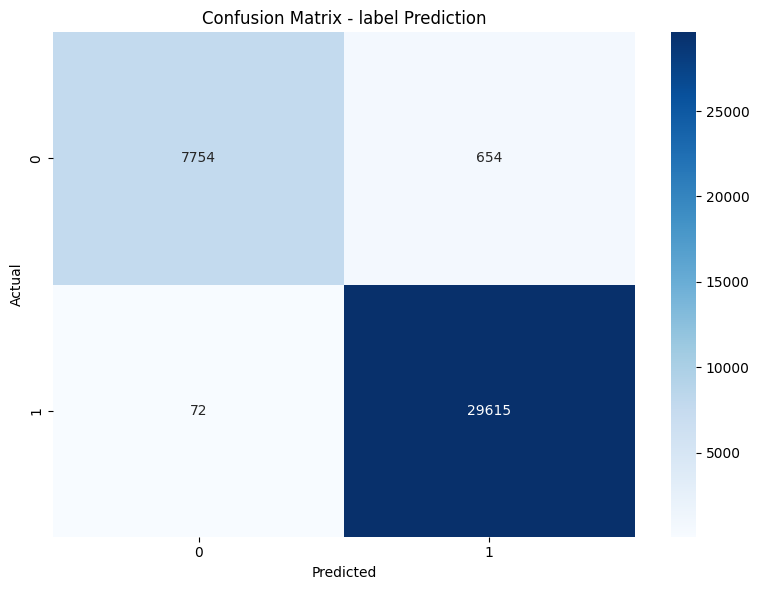


✅ Accuracy: 0.9809
✅ Weighted F1 Score: 0.9807
✅ Macro F1 Score: 0.9716
✅ Macro Precision: 0.9846
✅ Macro Recall: 0.9599
❌ Hamming Loss: 0.019058
📈 ROC AUC Score: 0.9871
📈 PR AUC Score: 0.9888


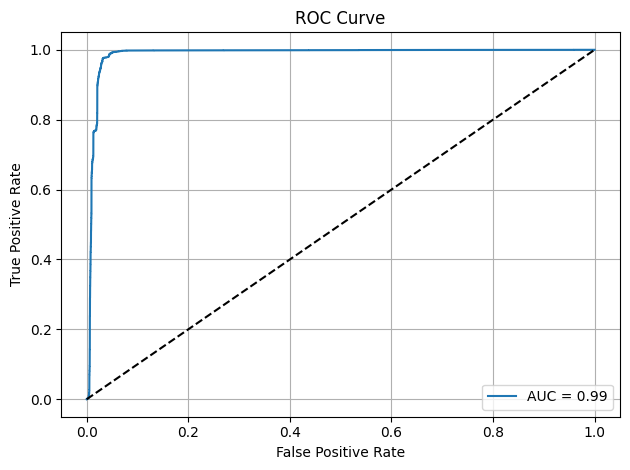

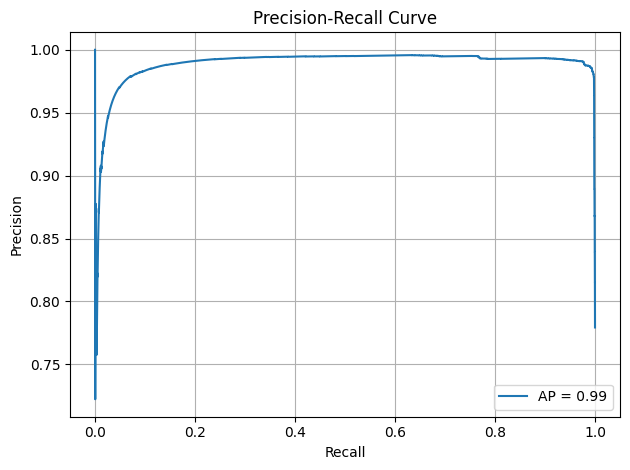

In [ ]:
display_metrics(y_test['label'], y_pred_logreg, "label Prediction",y_proba)


In [ ]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["type"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)



--- type Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.905739  0.991181  0.946536   3742.0
1   0.823228  0.882721  0.851937   3999.0
2   0.989435  0.912082  0.949185   3799.0
3   0.762439  0.629351  0.689532   3993.0
4   0.165510  0.802885  0.274445    208.0
5   0.982791  0.944101  0.963057   8408.0
6   0.722400  0.794058  0.756536   3972.0
7   0.865154  0.879539  0.872287   2947.0
8   0.949811  0.818500  0.879280   4000.0
9   0.832726  0.830525  0.831624   3027.0

📊 Confusion Matrix:


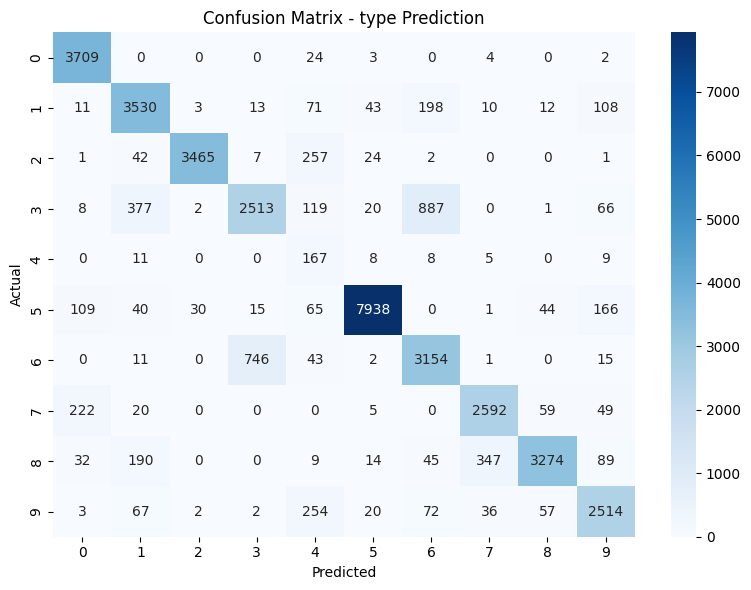


✅ Accuracy: 0.8625
✅ Weighted F1 Score: 0.8682
✅ Macro F1 Score: 0.8014
✅ Macro Precision: 0.7999
✅ Macro Recall: 0.8485
❌ Hamming Loss: 0.137525


In [ ]:
display_metrics(y_test['type'], y_pred_logreg, "type Prediction")

Stacked Model

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier(class_weight="balanced")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=200,class_weight="balanced")


stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=-1
)


stacked.fit(X_train, y_train["label"])



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


StackingClassifier(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_polic...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced'))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=200,
                                                      multi_class='multinomial'),
                   n_jobs=-1)


--- label ---

📋 Classification Report:
   precision    recall  f1-score  support
0   1.000000  0.999881  0.999941   8408.0
1   0.999966  1.000000  0.999983  29687.0

📊 Confusion Matrix:


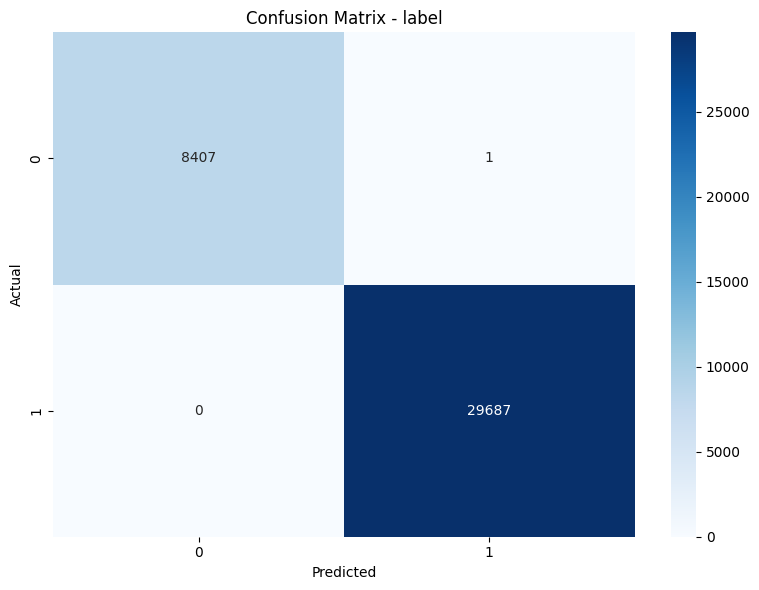


✅ Accuracy: 1.0000
✅ Weighted F1 Score: 1.0000
✅ Macro F1 Score: 1.0000
✅ Macro Precision: 1.0000
✅ Macro Recall: 0.9999
❌ Hamming Loss: 0.000026
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


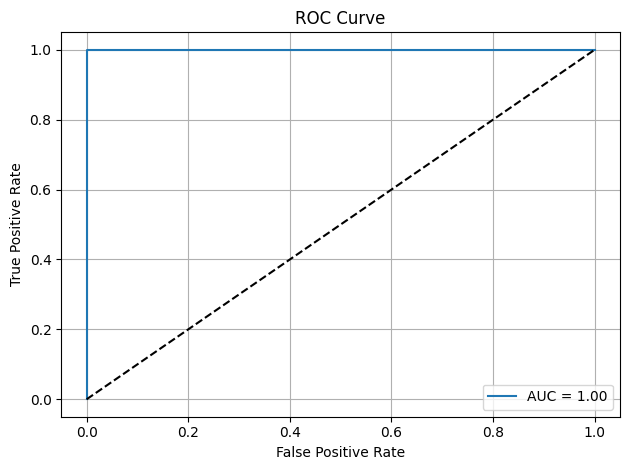

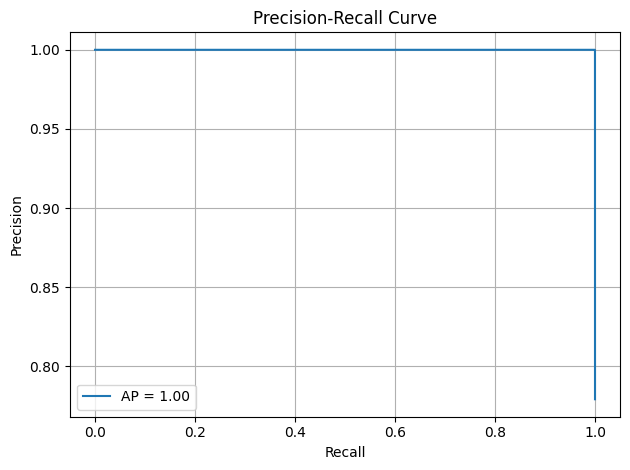

In [ ]:
y_pred_attack = stacked.predict(X_test)
y_proba = stacked.predict_proba(X_test)[:, 1]
display_metrics(y_test["label"], y_pred_attack,"label",y_proba)

In [ ]:
del y_proba,stacked
gc.collect()

51868

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:20:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:21:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be r


--- type ---

📋 Classification Report:
   precision    recall  f1-score  support
0   1.000000  1.000000  1.000000   3742.0
1   0.993989  0.992498  0.993243   3999.0
2   0.994452  0.990787  0.992616   3799.0
3   0.988520  0.991986  0.990250   3993.0
4   0.908654  0.908654  0.908654    208.0
5   1.000000  0.999881  0.999941   8408.0
6   0.994457  0.993706  0.994081   3972.0
7   1.000000  1.000000  1.000000   2947.0
8   0.992020  0.994500  0.993258   4000.0
9   1.000000  1.000000  1.000000   3027.0

📊 Confusion Matrix:


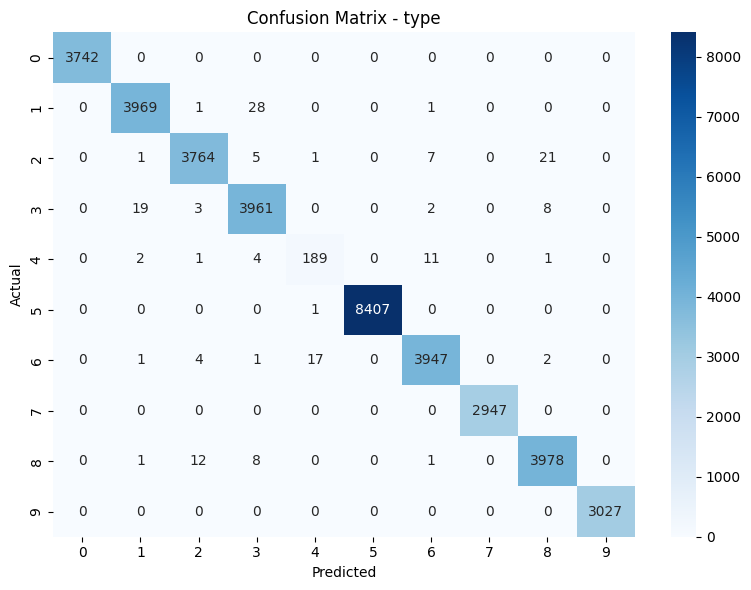


✅ Accuracy: 0.9957
✅ Weighted F1 Score: 0.9957
✅ Macro F1 Score: 0.9872
✅ Macro Precision: 0.9872
✅ Macro Recall: 0.9872
❌ Hamming Loss: 0.004305


In [ ]:

stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)
X_cat = np.concatenate([X_train, y_train["label"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_cat, y_train["type"])


X_cat_test = np.concatenate([X_test, y_pred_attack.reshape(-1, 1)], axis=1)

y_pred_category = stacked.predict(X_cat_test)
display_metrics(y_test["type"], y_pred_category,title="type")

